In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from csv file
data = pd.read_csv('/content/drive/MyDrive/MYLSTM/TimeLSTM.csv', parse_dates=['Time'], index_col='Time')

# Scale the data
scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data['Concentration'].values.reshape(-1, 1))

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Define a function to create the input and output sequences for the LSTM model
def create_sequences(data, window_size):
    x = []
    y = []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(x), np.array(y)

# Create the input and output sequences for the LSTM model
window_size = 10
x_train, y_train = create_sequences(train_data['Scaled'].values, window_size)
x_test, y_test = create_sequences(test_data['Scaled'].values, window_size)

# Reshape the input data into the shape required by the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Define the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(6, return_sequences=True, input_shape=(window_size, 1)))
model.add(keras.layers.LSTM(50)) ############################# Here 50 and 6 are units (neoron)  ########################
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(x_train, y_train, epochs=4000, batch_size=16) #, verbose=1)

# Make predictions using the trained LSTM model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)


Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 11ms/step - loss: 1.6353e-04
Epoch 1503/4000
12/12 [==============================] - 0s 12ms/step - loss: 2.0771e-04
Epoch 1504/4000
12/12 [==============================] - 0s 11ms/step - loss: 1.4380e-04
Epoch 1505/4000
12/12 [==============================] - 0s 13ms/step - loss: 1.1376e-04
Epoch 1506/4000
12/12 [==============================] - 0s 13ms/step - loss: 1.0529e-04
Epoch 1507/4000
12/12 [==============================] - 1s 83ms/step - loss: 1.0486e-04
Epoch 1508/4000
12/12 [==============================] - 0s 12ms/step - loss: 8.7902e-05
Epoch 1509/4000
12/12 [==============================] - 0s 10ms/step - loss: 8.3721e-05
Epoch 1510/4000
12/12 [==============================] - 0s 12ms/step - loss: 1.2661e-04
Epoch 1511/4000
12/12 [==============================] - 0s 11ms/step - loss: 1.0038e-04
Epoch 1512/4000
12/12 [==============================] - 0s 41ms/step - los

Give at most 3500 epochs in this case. If you see the trend of the loss function, you will understand that after 3500 epochs, the loss. Increases for a short time may be because of overfitting. As a general rule, when the loss becomes 0.001, stop training.
Also, to increase the accuracy of training, you can increase the number of units. but consire that time cost will increase and you may need to resuce the number of epochs.

Train RMSE: 0.0019
Test RMSE: 1.0820


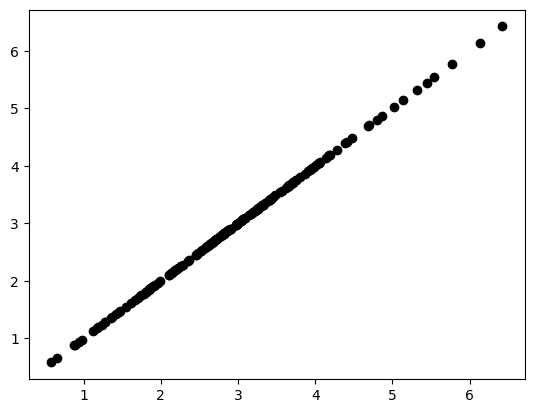

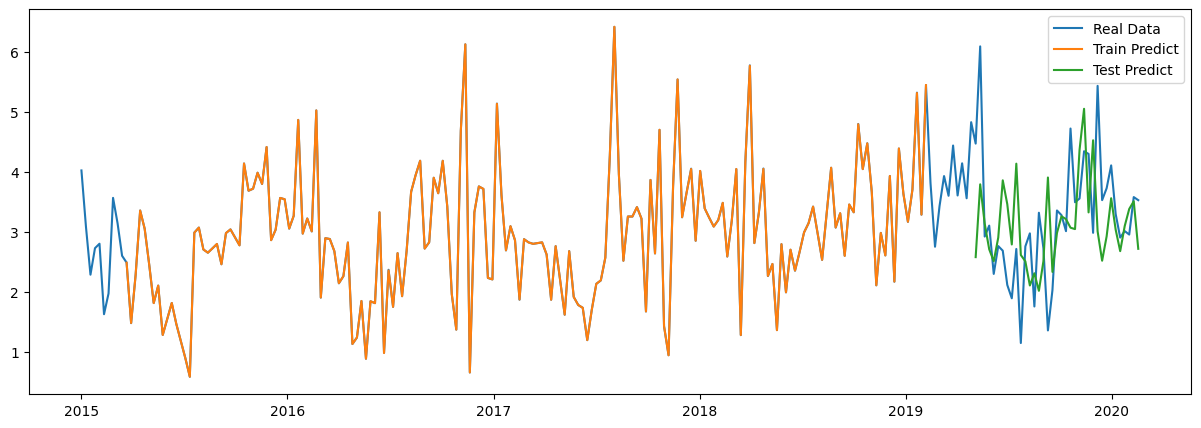

In [ ]:
# Invert the scaling of the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the root mean squared error (RMSE) of the predictions
train_rmse = np.sqrt(np.mean((train_predict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))

print('Train RMSE: {:.4f}'.format(train_rmse))
print('Test RMSE: {:.4f}'.format(test_rmse))

plt.scatter(y_train, train_predict, color="black")
r2values = r2_score(y_train, train_predict, force_finite=False)
r2valuetest = r2_score(y_test, test_predict, force_finite=False)

# Plot the real data and the predicted data
plt.figure(figsize=(15, 5))
plt.plot(data['Concentration'], label='Real Data')
plt.plot(data.index[window_size:len(train_predict)+window_size], train_predict.ravel(), label='Train Predict')
plt.plot(data.index[len(train_predict)+window_size*2:], test_predict.ravel(), label='Test Predict')
plt.legend()
plt.show()



1/1 [==============================] - 0s 25ms/step


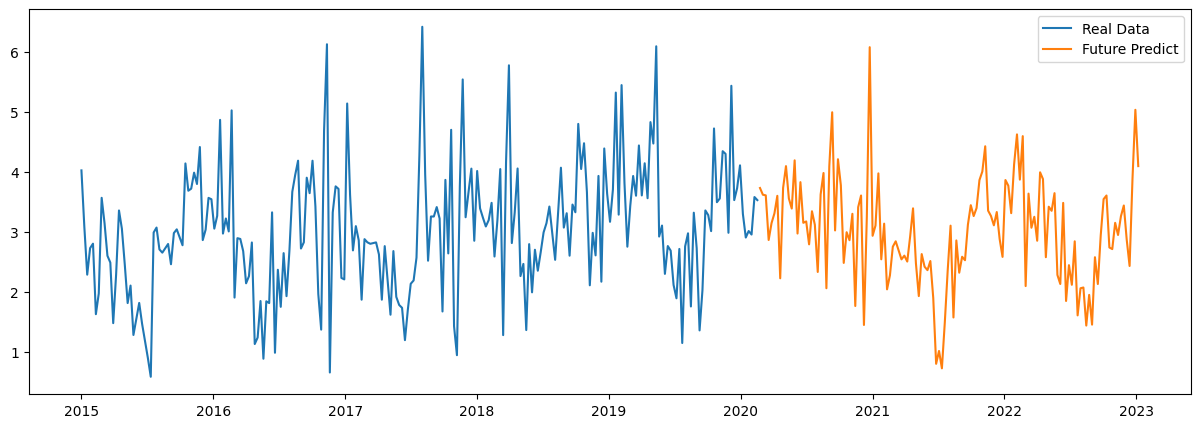

In [ ]:
# Predict future values using the trained LSTM model
#r2valuetest = r2_score(y_test, test_predict, force_finite=False)
future_dates = pd.date_range(start='2020-02-24', end='2023-01-8', freq='8D')
future_data = pd.DataFrame(index=future_dates)
future_data['Scaled'] = np.nan

last_window = data['Scaled'].values[-window_size:]
for i in range(len(future_dates)):
    last_window_reshaped = last_window.reshape(1, window_size, 1)
    future_pred_scaled = model.predict(last_window_reshaped)
    future_pred = scaler.inverse_transform(future_pred_scaled)
    future_data.iloc[i] = future_pred
    last_window = np.append(last_window[1:], future_pred_scaled)

future_data['Concentration'] = future_data['Scaled']
future_data.drop('Scaled', axis=1, inplace=True)

# Plot the real data and the predicted future data
plt.figure(figsize=(15, 5))
plt.plot(data['Concentration'], label='Real Data')
plt.plot(future_data['Concentration'], label='Future Predict')
plt.legend()
plt.show()


In [ ]:
pd.set_option('display.max_rows', None)
print(future_data)
org = np.concatenate([y_train, y_test])
pred = np.concatenate([train_predict, test_predict])
r2all = r2_score(org, pred, force_finite=False)

            Concentration
2020-02-24       3.729588
2020-03-03       3.617335
2020-03-11       3.606931
2020-03-19       2.861796
2020-03-27       3.143867
2020-04-04       3.306474
2020-04-12       3.599148
2020-04-20       2.222497
2020-04-28       3.730434
2020-05-06       4.094751
2020-05-14       3.553806
2020-05-22       3.386247
2020-05-30       4.191406
2020-06-07       2.969687
2020-06-15       3.827152
2020-06-23       3.148702
2020-07-01       3.171281
2020-07-09       2.789192
2020-07-17       3.341352
2020-07-25       3.114845
2020-08-02       2.328199
2020-08-10       3.622971
2020-08-18       3.979972
2020-08-26       2.056530
2020-09-03       4.091860
2020-09-11       4.993750
2020-09-19       3.021242
2020-09-27       4.209930
2020-10-05       3.775367
2020-10-13       2.479142
2020-10-21       2.991862
2020-10-29       2.858090
2020-11-06       3.299012
2020-11-14       1.759910
2020-11-22       3.409714
2020-11-30       3.604314
2020-12-08       1.443094
2020-12-16  